# SEN122A Statistical Analysis of Choice Behaviour 

## `Session Lab 02A:`
## `The Mixed Logit model`

**Delft University of Technology**<br>
**Q2 2024**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.


**Lab sessions are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.
* A good preparation for the graded partial exam.

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers, you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflection-oriented questions. <br>
Futhermore **be aware** that during the `partial exam`, you will not have access to these tools (since internet access will be restricted).

### `Workspace set-up`

**Option 1: Anaconda**<br>

Uncomment the following lines if you are running this notebook on your local environment and want to use ANACONDA to set up your Python environment. 

Please ensure that you have activated an environment that meets the Python version described in the readme file (*3.12.7, 3.11.10, or 3.10.15*).

In [ ]:
#!pip install -r requirements.txt

**Option 2: PIP**<br>
Uncomment the following cell if you are running this notebook on your local environment and want to use PIP to set-up your Python environment.

In [ ]:
#!pip install -r requirements.txt

**Option 3: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [ ]:
#!git clone https://github.com/SEN1221TUD/Q2_2024.git
#!mv "/content/Q2_2024/Lab_sessions/Lab_session_02/data" /content/data   

#!pip install biogeme
#import os
#os.kill(os.getpid(), 9)

### `Application: Estimating the Value of Travel Time`

In this lab session, we will investigate the "Value of Travel Time" (VTT) distribution. The VTT of a traveller reflects the amount of money the traveller is **willing to pay** to reduce their travel time. The VTT is used to determine the benefits of new infrastructure projects. As travel time savings are the dominant and most salient benefits of new infrastructure, accurate inference of the distribution of the VTT is crucial for a rigorous underpinning of policy decisions. <br>

During this lab, we will apply Mixed Logit choice models. We aim to uncover how tastes for travel time and travel cost are distributed in the population. Most of the analyses in this lab session are carried out in the so-called willingness-to-pay space. Willingness-to-pay space facilitates the inference of the VTT distribution.<br>

For this study, we will use Stated Choice (SC) data (`Norway_VTT_2009.csv`) collected in 2009 to compute the Norwegian VTT. In this SC experiment, respondents faced nine choice tasks involving two alternatives and two attributes (travel cost and travel time). The data set consists of 5,832 participants, resulting in a total of 52,488 choice observations. The figure below shows one of the choice tasks (note that for the purposes of illustration we converted the currency unit (Kronor) into euros).

![SC](data/sc_experiment.png)

**`Learning objectives lab session 02A`**

After completing the following exercises, you will be able to:
* Estimate Mixed Logit models that capture taste heterogeneity and panel effects
* Interpret the modelling outcomes of Mixed Logit models
* Specify utility models in Willingness-to-pay space



**`This lab consists of 4 parts and has 2 exercises`**

**Part 1**: Load and explore the data set

**Part 2**: Linear-additive RUM-MNL model

**Part 3**: Mixed Logit model for capturing taste heterogeneity 
- Exercise 1: "Mixed Logit model with a normally distributed beta_tt"

**Part 4**: Willingness-to-Pay space 
- Exercise 2: "Mixed Logit model with log-normally distributed VTT"



### `Import packages`

To begin, we will import all the libraries that we will use in this lab.

In [1]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.biogeme_logging as blog
from biogeme import models
from biogeme.expressions import Beta, Variable, bioDraws, log, MonteCarlo, exp, bioMultSum, exp


# General packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from pathlib import Path
from scipy.stats import norm, lognorm

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

We invoke a so-called `logger` which enables us to see the progress during estimation.<br>

In [2]:
# Initialize the logger, if it has not been initialized yet
try:
    logger
except NameError:    
    logger = blog.get_screen_logger(level=blog.INFO)
    print('Logger has been initialised')

Logger has been initialised


## `1. Load and explore the data set` <br>

First, we load the data.

In [3]:
# 1. Load the data set
data_path = Path('data/Norway_VTT_2009.csv')
df = pd.read_table(data_path, sep=',')

# Show descriptive statistics
round(df.describe(),2)

,RespID,CostL,CostR,TimeL,TimeR,Chosen,Mode,Purpose,Gender,AgeClass,IncClass
count,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.0
mean,32776.25,181.57,184.83,98.50,97.83,1.48,1.85,3.28,1.45,3.20,5.0
std,14995.46,281.07,286.95,134.33,133.42,0.50,1.80,1.64,0.50,0.99,2.3
min,32.00,4.00,4.00,6.00,6.00,1.00,1.00,1.00,1.00,1.00,1.0
25%,19195.25,25.00,25.00,18.00,17.00,1.00,1.00,2.00,1.00,2.00,4.0
50%,33039.50,69.00,70.00,40.00,40.00,1.00,1.00,4.00,1.00,3.00,5.0
75%,45333.00,236.00,238.00,121.00,122.00,2.00,2.00,5.00,2.00,4.00,6.0
max,60130.00,5282.00,5221.00,2011.00,1855.00,2.00,8.00,5.00,2.00,5.00,11.0


This data set contains the following variables:<br>

| Variable       | Description                                                  | Type    |
|---------------|-------------------------------------------------------------|---------|
| `RespID`        | Unique identifier for each survey response             | Integer |
| `CostL`         | Travel cost of left alternative [min]                  | Decimal |
| `CostR`         | Travel cost of right alternative [min]                 | Decimal |
| `TimeL`         | Travel time of left alternative [eur]                  | Decimal |
| `TimeR`         | Travel time of right alternative [eur]                 | Decimal |
| `Chosen`        | Indicates the alternative chosen       | Categorical |
| `Mode`          | Type of Transport mode               | Categorical    |
| `Gender`        | Gender of the respondent                                     | Categorical    |
| `AgeClass`      | Classification of the respondent's age                       | Categorical    |
| `IncClass`      | Classification of the respondent's income                    | Categorical    |
| `Purpose`       | Purpose of the trip                                     | Integer    |


Now, we take the following data preprocessing steps:

1. We keep only observations for the purpose 'long distance commute' and travel model 'car'.

2. We convert the unit of cost from Norwegian Krone to euros to ease interpretation.

In [4]:
# 1. Keep only entries purpose == 5 (Long distance trips) & Mode == 1 (Car)
df = df.loc[(df['Purpose'] == 5) & (df['Mode'] == 1)]

In [5]:
# 2. Convert the monetary unit to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

## `2. Linear-additive RUM-MNL model`<br>
We first estimate a linear-aditive RUM-MNL model. This model serves as our **benchmark** to compare against. But, before we can do this, we need to create the Biogeme database object and specify the optimiser and logger settings. 

`Biogeme database`<br>
To estimate a model in Biogeme, we must create the data set as a Biogeme database object and the attributes as Biogeme variable objects.

In [6]:
# Create Biogeme database object
biodata = db.Database('Norway2009VTT', df)

# Create Biogeme variable objects
CostL  = Variable('CostL')
CostR  = Variable('CostR')
TimeL  = Variable('TimeL')
TimeR  = Variable('TimeR')
Chosen = Variable('Chosen')	

`Create a linear-additive RUM-MNL model`<br>
Now, we have the biogeme database object and set the environment, we can estimate our first model.

In [7]:
# Give the model a name
model_name = 'Benchmark MNL VTT model'

# Define model parameters
B_tt = Beta('B_tt', -0.1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)

# Definition of the utility functions
VL = B_tt * TimeL + B_tc * CostL
VR = B_tt * TimeR + B_tc * CostR

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
av = {1: 1, 2: 1} 

# Compute probability of the chosen alternative
prob = models.logit(V, av, Chosen)

# Take the log of the probability
logprob = log(prob)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata, logprob)

# Compute the null loglikelihood for reporting
biogeme.nullLogLike = biogeme.calculate_null_loglikelihood(av)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

Biogeme parameters read from biogeme.toml. 


In [8]:
# Estimate the MNL model and print the results
results = biogeme.estimate()
print(results.print_general_statistics())

# Get the results in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

As the model is not too complex, we activate the calculation of second derivatives. If you want to change it, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
As the model is not too complex, we activate the calculation of second derivatives. If you want to change it, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc            B_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1      1.3e+04         13     0.14    -0.91    - 
    1          -0.059           0.042      1.1e+04         10     0.14     0.14    + 
    2          -0.059           0.042      1.1e+04         10    0.071     -3.1    - 
    3          -0.059           0.042      1.1e+04         10    0.035    -0.12    - 
    4          -0.023          0.006

Number of estimated parameters:	2
Sample size:	10926
Excluded observations:	0
Null log likelihood:	-7573.326
Init log likelihood:	-12639.01
Final log likelihood:	-6033.756
Likelihood ratio test for the null model:	3079.141
Rho-square for the null model:	0.203
Rho-square-bar for the null model:	0.203
Likelihood ratio test for the init. model:	13210.51
Rho-square for the init. model:	0.523
Rho-square-bar for the init. model:	0.522
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11
Final gradient norm:	1.5496E-04
Nbr of threads:	11

         Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.107428      0.003714   -28.921834           0.0
B_tt -0.033949      0.001366   -24.852251           0.0


`Compute the Value of Travel Time`<br><br>
The linear-additive RUM-MNL model allows for easy computation of the (mean) VTT. <br>

$VTT = {\frac{dV}{dtt}}/{\frac{dV}{dtc}}$<br><br>
$VTT = \frac{\beta_{tt}}{\beta_{tc}}$

To take the ratio, we access the estimated betas in the `beta_hat` dataframe that was created in the previous cell.

In [9]:
# Compute the value of travel time and print the mean VTT
# We multiply by 60 to convert the value of travel time from minutes to hours
VTT_MNL = 60*(beta_hat.loc['B_tt']['Value']/beta_hat.loc['B_tc']['Value'])
print(f'Value of travel time MNL model:  €{VTT_MNL:.2f} per hour')

Value of travel time MNL model:  €18.96 per hour


## `3. Mixed Logit model for capturing taste heterogeneity`

### `3.1 Theory`<br>
In the MNL model, we postulate that tastes (e.g., 𝛽_tc) are equal across people in the population. As such, the taste parameter of an MNL model represents the mean taste in the population. The Mixed Logit (ML) model resolves this limitation. It explicitly models taste heterogeneity by means of random variables.

Mathematically, the unconditional choice probability is given by:

$P_{ni} = \int_{\beta_n}    [P_{ni}|\beta_n] \cdot f(\beta_n|\sigma)d\beta_n$

As can be seen, the ML choice probability does not have a closed-form expression. Therefore, it needs to be approximated using simulation.<br>
To do that, we simulate the choice probabilities using a large number of draws `(R)` from the density function $f(β_n|\sigma)$. <br>
That is, we compute the conditional choice probability (which is a simple MNL) for each draw of $\beta_n^{r}$ with $r=1,..,R$, and then take the average across the draws to compute the unconditional choice probability.

<span style="text-decoration: overline;">P</span>$_{ni} = \frac{1}{R} \sum_{r=1}^R P_{ni}(β_n^r)$

Finally, we use the unconditional choice probabilities to compute the Log-Likelihood of the data given the model:

$LL(X,|\beta,\sigma)= \sum_{n=1}^N \sum_{j=1}^J y_{nj} \cdot ln($<span style="text-decoration: overline;">P</span>$_{nj})$

### `3.2 ML with normally distributed taste parameters`

To estimate an ML, model with normally distributed taste parameters, we must specify the random parameters (for all randomly distributed betas that we wish to estimate). To do this in Biogeme, we use the following code to construct the random parameter for $\beta_{tt}$:<br>

                B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

Note that apart from the random parameter for B_tt_rnd, the utility function is the same as under our linear-additive RUM-MNL benchmark model

`Model specification` <br>

Now, we will define random and nonrandom parameters, the utility functions, and their availabilities. <br>

In [10]:
# Define the model parameters
B_tt = Beta('b_tt', -0.1, None, None, 0)
B_tc = Beta('b_tc', -0.1, None, None, 0)    
sigma_tt = Beta('sigma_tt', 1, None, None, 0)
sigma_tc = Beta('sigma_tc', 1, None, None, 0)

# Construct the random taste parameter for beta_tt
B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')
B_tc_rnd = B_tc + sigma_tc * bioDraws('B_tc_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
V_L = B_tt_rnd * TimeL + B_tc_rnd * CostL
V_R = B_tt_rnd * TimeR + B_tc_rnd * CostR   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

`Estimation through simulation` 

We use the Monte Carlo simulation to estimate the random parameter. 

In [11]:
# Give the model a name
model_name = 'ML with normal distributed B_tt and B_tc'

# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
num_draws = 100
biogeme = bio.BIOGEME(biodata , LL,number_of_draws=num_draws)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

Biogeme parameters read from biogeme.toml. 


In [12]:
# Estimate the model and print the results
results = biogeme.estimate()

# Print the results in a table
# Note that print_general_statistics() gives more information than short_summary(), which we used before
print(results.print_general_statistics())

# Get the estimated parameters in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
The number of draws (100) is low. The results may not be meaningful. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
Iter.            b_tc            b_tt        sigma_tc        sigma_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1               1               1      7.6e+03        1.9      0.5     0.02    - 
    1            -0.1            -0.1               1               1      7.6e+03        1.9     0.25    0.069    - 
    2           -0.35   

Number of estimated parameters:	4
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-7641.489
Final log likelihood:	-5549.062
Likelihood ratio test for the init. model:	4184.855
Rho-square for the init. model:	0.274
Rho-square-bar for the init. model:	0.273
Akaike Information Criterion:	11106.12
Bayesian Information Criterion:	11135.32
Final gradient norm:	4.4397E-01
Number of draws:	100
Draws generation time:	0:00:00.832968
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2']
Nbr of threads:	11

             Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc     -1.020582      0.290921    -3.508113      0.000451
b_tt     -0.259188      0.071953    -3.602177      0.000316
sigma_tc -0.407975      0.121752    -3.350881      0.000806
sigma_tt  0.164019      0.052703     3.112130      0.001857


### `3.3 Reflection`<br>
We can make the following observations from the results of the ML model:
1. The model fits the data better than the linear-additive RUM-MNL model. So this model is preferred over the linear-additive RUM-MNL model.
2. The estimated standard deviations of the random parameters are significant, indicating that there is substantial taste heterogeneity in the population.


**However**, the ML model with two normally distributed random parameters does not provide a way to compute the VTT. When we would compute the VTT by taking the ratio of $\beta_{time}$ over $\beta_{cost}$ we end up dividing by $\beta_{tc}$ because the **normal** distribution has mass at zero. In other words, the model predicts some people don't care about cost. This implies they would have a infinite VTT, and the mean VTT would be infinite as well. Thus, a normally distributed $\beta_{tc}$ is generally not a good idea if one want to compute the VTT.

## `Exercise 1: Mixed Logit model with a normally distributed beta_tt`

`A` Modify the code to estimate the ML model above, such that the model only treat  $\beta_{tt}$ as a random variable.

`B` Compute the **mean** VTT for the model with only $\beta_{tt}$ as a random variable. The mean of a normal distribution is given by the mean of the random parameter. So, the mean VTT is given by  VTT_ML = $60\cdot \frac{\beta_{tt}}{\beta_{tc}}$.

#### `Answers`

In [13]:
# A. 
# Define the model parameters
B_tt = Beta('b_tt', -0.1, None, None, 0)
B_tc = Beta('b_tc', -0.1, None, None, 0)    
sigma_tt = Beta('sigma_tt', 1, None, None, 0)

# Construct the random taste parameter for beta_tt
B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')


# Definition of the utility functions 
V_L = B_tt_rnd * TimeL + B_tc * CostL
V_R = B_tt_rnd * TimeR + B_tc * CostR   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

# Give the model a name
model_name = 'ML with normal distributed B_tt only'

# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
num_draws = 100
biogeme = bio.BIOGEME(biodata , LL,number_of_draws=num_draws)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

# Estimate the model and print the results
results = biogeme.estimate()

# Print the results in a table
# Note that print_general_statistics() gives more information than short_summary(), which we used before
print(results.print_general_statistics())

# Get the estimated parameters in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

Biogeme parameters read from biogeme.toml. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
The number of draws (100) is low. The results may not be meaningful. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
Iter.            b_tc            b_tt        sigma_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1               1      7.5e+03       0.35      0.5      -36    - 
    1            -0.1            -0.1               1      7.5e+03       0.35     0.25    -0.59    - 
    2           -0.35       

Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-7539.439
Final log likelihood:	-5743.571
Likelihood ratio test for the init. model:	3591.737
Rho-square for the init. model:	0.238
Rho-square-bar for the init. model:	0.238
Akaike Information Criterion:	11493.14
Bayesian Information Criterion:	11515.04
Final gradient norm:	2.6548E-01
Number of draws:	100
Draws generation time:	0:00:00.684760
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2']
Nbr of threads:	11

             Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc     -0.466620      0.112904    -4.132877      0.000036
b_tt     -0.142610      0.033755    -4.224823      0.000024
sigma_tt  0.200312      0.061519     3.256082      0.001130


In [14]:
# B
# Compute the mean value of travel time
VTT_ML = 60*(beta_hat.loc['b_tt']['Value']/beta_hat.loc['b_tc']['Value'])
print(f'Value of travel time ML model:  €{VTT_ML:.2f} per hour')

Value of travel time ML model:  €18.34 per hour


## `4. Willingness-to-Pay space`

### `4.1. Theory`<br>

People are differently sensitive to cost. But, as discussed under 3.3, we cannot specify $\beta_{tc}$ as a randomly distributed parameter (or, to be more precise, not as one that uses a distribution which has support over the full domain, like a normal distribution). To circumvent this problem, we can cleverly re-parameterise our model. This reparametrisation involves a transformation from **`utility space`** to **`Willingness-to-Pay (WTP) space`**. This transformation allows us to estimate the VTT (distribution) directly, and simplifies the modelling. It works as follows:<br><br>


The utility specification in `utility space` is:

$V_1 = \beta_{tc} \cdot TC_1 + \beta_{tt} \cdot TT_1$<br>
$V_2 = \beta_{tc} \cdot TC_2 + \beta_{tt} \cdot TT_2$<br><br>

We factorise $\beta_{tc}$ in both utility functions. This gives us:

$V_1 = \beta_{tc} \cdot (TC_1 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_2)$<br><br>

Noting that $VTT = \frac{\beta_{tt}}{\beta_{tc}}$, we obtain:

$V_1 = \beta_{tc} \cdot (TC_1 + VTT \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + VTT \cdot TT_2)$<br><br>

Hence, with this model, we can directly estimate the VTT (and $\beta_{tc}$). Therefore, this model is in the `Willingness-to-Pay space`.<br> 

**Starting values for estimating the VTT in the WTP space**<br>
Whenever we estimate a discrete choice model, we need to provide starting values for the optimisation algorithm. For conventional linear-additive RUM-MNL models, the starting values are inconsequential because of its concave log-likelihood function. However, for models estimated in WTP space and more complex models in general, the starting values can have impact. When estimating the VTT in the WTP space, it is good practice to provide reasonable starting values (thus a nonzero, positive VTT).

In the WTP space, we can use the following heuristic to determine the starting values for the VTT:<br>
Let's first see how this works out for a simple MNL model:

In [15]:
# Give the model a name
model_name = 'Benchmark MNL in WTP space'

# Define model parameters
vtt  = Beta('vtt', 10/60, None, None, 0) # Note thate we use VTT of 10 euros/hr as the starting value
B_tc = Beta('B_tc', -0.1, None, None, 0) # Note that we use a reasonable starting value for B_tc (same as in the MNL model)

# Definition of the utility functions
VL = B_tc * (CostL + vtt * TimeL)
VR = B_tc * (CostR + vtt * TimeR)

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
av = {1: 1, 2: 1} 

# Compute probability of the chosen alternative
prob = models.logit(V, av, Chosen)

# Take the log of the probability
logprob = log(prob)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata, logprob)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculate_null_loglikelihood(av)

# Estimate the parameters and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

Biogeme parameters read from biogeme.toml. 
As the model is not too complex, we activate the calculation of second derivatives. If you want to change it, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
As the model is not too complex, we activate the calculation of second derivatives. If you want to change it, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc             vtt     Function    Relgrad   Radius      Rho      
    0            -0.1            0.17      6.4e+03       0.89      0.5      -12    - 
    1            -0.1            0.17      6.4e+03       0.89     0.25     -3.9    - 
    2            -0.1            0.17      6.4e+03       0.89     0.12    -0.17    - 
    3           -0.11            0.29      6.1e+03       0.23     0.12     0.8

Results for model Benchmark MNL in WTP space
Nbr of parameters:		2
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-6033.756
Likelihood ratio test (null):		3079.141
Rho square (null):			0.203
Rho bar square (null):			0.203
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11

         Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.107431      0.003715   -28.921076           0.0
vtt   0.316010      0.006203    50.944495           0.0


In [16]:
# Compute the value of travel time
VTT_WTP_MNL = 60 * beta_hat.loc['vtt']['Value']
print(f'Value of travel time MNL model in WTP space:  €{VTT_WTP_MNL:.2f} per hour')

Value of travel time MNL model in WTP space:  €18.96 per hour


### `4.2 Reflection`<br>
Comparing these results with the benchmark MNL VTT model, we make two observations:
* We obtain `EXACTLY` the same VTT
* We obtain `EXACTLY` the same model fit 
* **We immediately obtain the VTT and the associated standard error!** 


### `4.3. ML in Willingness-to-Pay space`

`ML with normally distributed taste parameters`<br>
Now, let's see how WTP space enables us to directly estimate the VTT distribution in the context of the Mixed Logit model.

In [17]:
# Give the model a name
model_name = 'ML WTP space with normally distributed vtt'

# Parameters definition enabling the construction of random parameters
vtt = Beta('vtt',    0.1, None, None, 0)
B_tc = Beta('b_tc', -0.1, None, None, 0)    
sigma_vtt = Beta('sigma_vtt', 1, None, None, 0)

# Construction of random parameters   
vtt_rnd = vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
V_L = B_tc * (CostL + vtt_rnd * TimeL)
V_R = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

In [18]:
# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
num_draws = 100
biogeme = bio.BIOGEME(biodata , LL,number_of_draws=num_draws)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

Biogeme parameters read from biogeme.toml. 


In [19]:
# Estimate the model and print the results
results = biogeme.estimate()

# Print the results in a table
# Note that print_general_statistics() gives more information than short_summary(), which we used before
print(results.print_general_statistics())

# Get the estimated parameters in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
The number of draws (100) is low. The results may not be meaningful. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
Iter.            b_tc       sigma_vtt             vtt     Function    Relgrad   Radius      Rho      
    0            -0.1               1             0.1      6.3e+03       0.37      0.5      -44    - 
    1            -0.1               1             0.1      6.3e+03       0.37     0.25    -0.35    - 
    2           -0.35            0.75            0.35      6.1e+03      

Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-6317.555
Final log likelihood:	-5748.894
Likelihood ratio test for the init. model:	1137.323
Rho-square for the init. model:	0.09
Rho-square-bar for the init. model:	0.0895
Akaike Information Criterion:	11503.79
Bayesian Information Criterion:	11525.68
Final gradient norm:	5.7237E-01
Number of draws:	100
Draws generation time:	0:00:00.698092
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2', 'vtt_rnd: NORMAL_HALTON2']
Nbr of threads:	11

              Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc      -0.429096      0.081825    -5.244082  1.570625e-07
sigma_vtt  0.421579      0.029909    14.095533  0.000000e+00
vtt        0.306419      0.006510    47.072410  0.000000e+00


In [20]:
# Compute the value of travel time
VTT_WTP_ML = 60*beta_hat.loc['vtt']['Value']
print(f'Value of travel time ML model in WTP space:  €{VTT_WTP_ML:.2f} per hour')

Value of travel time ML model in WTP space:  €18.39 per hour


`Visualisation of the estimated VTT distribution`<br>
Visualisation of the estimated distribution helps to get a feeling for the shape of the distribution that we aim to recover. To do so, we use the estimated values for the mean (vtt) and standard deviation (sigma_vtt). <br>
Note that the visualisation distinguishes between values in the positive and negative domains.

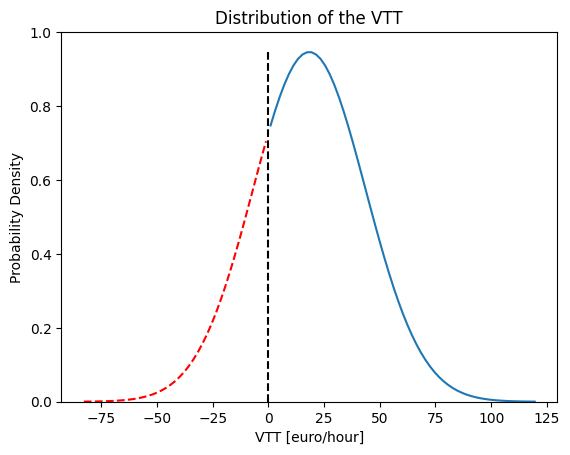

In [21]:
# Plot the estimated normal distribution

# Get the mean and standard deviation from the beta_hat table
mean_normal = beta_hat.loc['vtt']['Value']
std_dev_normal = beta_hat.loc['sigma_vtt']['Value']

# Create a vector of 100 points between +/- 4 standard deviations from the mean
x= np.linspace(mean_normal - 4*std_dev_normal, mean_normal + 4*std_dev_normal, 100)

# Plot the normal distribution in the positive domain. 
# Note that the x-axis is rescaled by 60 to convert from minutes to hours
# The scipy function "norm.pdf(x,mean, std_dev)" computes the probability density function of the normal distribution
plt.plot(x[x>0]*60, norm.pdf(x[x>0], mean_normal, std_dev_normal))

# Plot the normal distribution in the negative domain. 
plt.plot(x[x<0]*60, norm.pdf(x[x<0], mean_normal, std_dev_normal), color='red',linestyle='dashed')

# Add a vertical line to highlight the zero
plt.plot([0,0], [0,np.max(norm.pdf(x[x>0], mean_normal, std_dev_normal))], color='black',linestyle='dashed')

# Add labels and title
plt.xlabel('VTT [euro/hour]')
plt.ylabel('Probability Density')
plt.ylim([0,1])
plt.title(f'Distribution of the VTT')
plt.show()

### `4.4 Reflection`<br>
* Using a Mixed Logit model in the Willingness-to-Pay space, we are able to estimate the distribution of the VTT **directly** . Hence, this model allows jointly for unobserved heterogeneity in cost and time without running into problems caused by dividing by zero.  
* But, we see that a substantial part of the VTT distribution lies in the negative domain. This is behaviourally counterintuitive. In general, people prefer to arrive quicker at their destination rather than later. This is due to the assumption that the VTT is normally distributed. Perhaps this assumption needs revisiting...


## `Exercise 2: Mixed Logit with log-normally distributed VTT`

Now, **you** will try the assumption that the VTT distribution in the population is **`log-normally distributed`** (as opposed to normally distributed).<br>

To do that, you must create a random vtt parameter with a log-normal VTT distribution. Draws from the log-normal distribution can be obtained from draws from the normal distribution as follows: <br>

            vtt_rnd = exp(mu + sigma  * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))
            

Estimate this model and interpret its results.<br>



`A` Compare the log-likelihood of the ML model with normal distribution and with log-normal distribution. Which model fits better?<br>

`B` What can you conclude from the `vtt` and `sigma` parameters?<br>

`C` Compute the mean of the estimated log-normal distribution, i.e. `mean_lognormal` (based on your estimated `mu` and `sigma`). <br>

**Hint**, take a look at [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) to see how this is done. Look for the formula for the mean in the right-hand side panel on the web page.

`D` Plot the shape of the log-normal distribution for the estimated `mu` and `sigma`. <br>

 **Hint**, you can use the  scipy function "lognorm". But lognorm is differently parameterised. That is, instead of using a location parameter `mu`, it requires a `scale` parameter. The scale is simply the exponent of the location parameter mu (i.e. scale = exp(mu)). <br>
    
Alternatively, you compute it directly from the formula yourself using the location `mu` and standard deviation $\sigma$:<br>
    ${\frac {1}{x\sigma {\sqrt {2\pi }}}}\ \exp \left(-{\frac {\left(\ln x-\mu \right)^{2}}{2\sigma ^{2}}}\right)$

#### `Answers`

In [22]:
# Give the model a name
model_name = 'ML WTP space with log-normally distributed VTT'

# Parameters definition enabling the construction of random parameters
mu   = Beta('mu',     -1, None, None, 0)
B_tc = Beta('b_tc', -1, None, None, 0)    
sigma  = Beta('sigma', 1, None, None, 0)

# Construction of random parameters   
vtt_rnd = exp(mu + sigma * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

# Definition of the utility functions 
V_L = B_tc * (CostL + vtt_rnd * TimeL)
V_R = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

In [23]:
# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
num_draws = 100
biogeme = bio.BIOGEME(biodata , LL,number_of_draws=num_draws)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.save_iterations = False
biogeme.modelName = model_name

# Estimate the parameters
results = biogeme.estimate()
print(results.print_general_statistics())

# Get the results in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

Biogeme parameters read from biogeme.toml. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
The number of draws (100) is low. The results may not be meaningful. 
As the model is rather complex, we cancel the calculation of second derivatives. If you want to control the parameters, change the name of the algorithm in the TOML file from "automatic" to "simple_bounds" 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
Iter.            b_tc              mu           sigma     Function    Relgrad   Radius      Rho      
    0              -1              -1               1        6e+03       0.34      0.5     -0.7    - 
    1            -0.5            -1.5             1.5      5.7e+03      0.094      0.5     0.28    + 
    2            -0.5       

Number of estimated parameters:	3
Sample size:	10926
Excluded observations:	0
Init log likelihood:	-6000.85
Final log likelihood:	-5570.737
Likelihood ratio test for the init. model:	860.2251
Rho-square for the init. model:	0.0717
Rho-square-bar for the init. model:	0.0712
Akaike Information Criterion:	11147.47
Bayesian Information Criterion:	11169.37
Final gradient norm:	1.8641E-01
Number of draws:	100
Draws generation time:	0:00:00.695217
Types of draws:	['B_tc_rnd: NORMAL_HALTON2', 'B_tt_rnd: NORMAL_HALTON2', 'vtt_rnd: NORMAL_HALTON2']
Nbr of threads:	11

          Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc  -0.930133      0.165560    -5.618099  1.930693e-08
mu    -1.463983      0.020639   -70.933025  0.000000e+00
sigma  1.126130      0.029088    38.715121  0.000000e+00


`A` Compare the log-likelihood of the ML model with normal distribution and with log-normal distribution. Which model fits better?<br>

        --> The log-normal distribution fits better, as it has a higher log-likelihood (-5570.737 vs -5739.896)

`B` What can you conclude from the `vtt` and `sigma` parameters?<br>

        --> The parameters are significant, and negative. But furthermore hard to interpret

`C` Compute the mean of the estimated log-normal distribution, i.e. `mean_lognormal` (based on your estimated `mu` and `sigma`) <br>

        --> The mean of the log-normal VTT distribution is €25.99 per hour

In [24]:
mu = beta_hat.loc['mu']['Value']
sigma = beta_hat.loc['sigma']['Value']
mean_lognormal = np.exp(mu + np.square(sigma)/2) * 60
print(f'The mean of the log-normal VTT distribution is: €{mean_lognormal:.2f} per hour')

The mean of the log-normal VTT distribution is: €26.17 per hour


4. Plot the shape of the log-normal distribution using the estimated mu and sigma

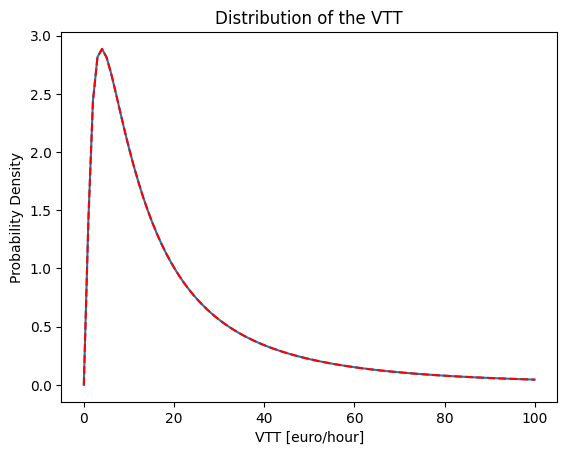

In [25]:
# Plot the estimated log-normal distribution
x = np.linspace(0.0001, 100/60, 100)

# Compute the pdf of the log-normal distribution, based on mu and sigma_sq
pdf_lognorm1 = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-np.square(np.log(x)-mu)/(2*np.square(sigma)))
pdf_lognorm2 = lognorm.pdf(x, s = sigma, scale= np.exp(mu))

# Plot the log-normal distribution. Note that x is rescaled by 60 to convert from minutes to hours
plt.plot(x*60, pdf_lognorm1)
plt.plot(x*60, pdf_lognorm2, color='red',linestyle='dashed')

# Add labels and title
plt.xlabel('VTT [euro/hour]')
plt.ylabel('Probability Density')
# plt.ylim([0,3])
plt.title(f'Distribution of the VTT')
plt.show()

## END